In [2]:
import astropy
import numpy as np
import pandas as pd
import scipy
import numpy
import pyspeckit
import zipfile
import os
import re
import matplotlib.pyplot as plt
from matplotlib import style
from astropy.table import QTable,Table,Column,MaskedColumn
from astropy.io import ascii
from sklearn.metrics import auc
from openpyxl import load_workbook
import xlrd
from tabulate import tabulate
import seaborn as sb
from scipy.stats import chisquare
import emcee

###

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
def lectura(route):
    return Table.read(route,format='ascii')

def stof_list(lista):
    return [float(i) for i in lista]

def extinctions(tabla,extinction,cantidad):
    salida =[]
    if cantidad > 0:
        
        for N in range(1,cantidad+1):
            aux = [W['Magnitud']+(N*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad < 0:
        
        cantidad = round((cantidad**2)**(1/2))
        for M in range(0,cantidad+1):
            aux = [W['Magnitud'] - (M*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad == 0:
        salida.append([W['Magnitud'] for W in tabla])
        
    return salida

def parametro_extincion(tabla,extinction,cantidad):
    salida =[]
    if cantidad > 0:
        
        for N in range(1,cantidad+1):
            aux = [(N*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad < 0:
        
        cantidad = round((cantidad**2)**(1/2))
        for M in range(0,cantidad+1):
            aux = [(M*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad == 0:
        salida.append([extincion for W in tabla])
        
    return salida

def chi2(observed_point,expected_point):
    observed = ((observed_point[0])**(2)+(observed_point[1])**(2))**(1/2)
    expected = ((expected_point[0])**(2)+(expected_point[1])**(2))**(1/2)
    aux = (observed-expected)**(2)
    return aux/expected

def u(point1,point2):
    x2 = (point2[0] - point1[0])**(2)
    y2 = (point2[1] - point1[1])**(2)
    return np.sqrt(x2+y2)

def unique(lista):
    aux = []
    for i in lista:
        if i not in aux:
            aux.append(i)
    return aux

def limites(lista_color):
    return [(min(min(lista_color))),(max(max(lista_color)))]

def extremos(ejex,ejey):
    puntos_maximos_xy = [] #cada lista contiene por modelo puntos de los limites superiores e inferiores para construir una regresion
    puntos_minimos_xy = []
    for model,model2 in zip(ejex,ejey):
        aux_puntos_maximos = []
        aux_puntos_minimos = []
        #print(len(model),len(model2))
        #print('\n')
        for s,s2 in zip(model,model2):

            indice_maximo_s2 = s2.index(max(s2))
            #print(s[indice_s2],max(s2))
            punto_maximo=(s[indice_maximo_s2],max(s2))
            aux_puntos_maximos.append(punto_maximo)
        
            indice_minimo_s2 = s2.index(min(s2))
            punto_minimo = ((s[indice_minimo_s2],min(s2)))
            aux_puntos_minimos.append(punto_minimo)
        puntos_maximos_xy.append(aux_puntos_maximos)    
        puntos_minimos_xy.append(aux_puntos_minimos)
    return [puntos_maximos_xy,puntos_minimos_xy]

def rectas(x,y):
    X = np.array(x)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(
                                            X.reshape(-1,1),
                                            y.reshape(-1,1),
                                            train_size   = 0.5,
                                            random_state = 1234,
                                            shuffle      = True
                                        )
    modelo = LinearRegression()
    modelo.fit(X = X_train.reshape(-1, 1), y = y_train)
    return(float(modelo.coef_[0]),modelo.intercept_[0])

In [4]:
#datos fotometricos de Candidatos oficiales
routes = [f'candidatos/{alpha}' for alpha in os.listdir('candidatos') if alpha != '.DS_Store' and alpha !='filtrados' and alpha!='Select1.txt' and alpha!='Select2.txt' and alpha!='Extincion_candidatos']
names = [string[:(len(string)-4)] for string in os.listdir('candidatos') if string != '.DS_Store' and string !='filtrados' and string!='Select1.txt' and string!='Select2.txt' and string!='Extincion_candidatos']
tablas = [lectura(dato) for dato in routes]
tablas2 = [dato2[dato2['cl']=='3'] for dato2 in tablas]

us = [data['umag'] for data in tablas2]
gs = [data['gmag'] for data in tablas2]
rs = [data['rmag'] for data in tablas2]
i_s = [data['imag'] for data in tablas2]
zs = [data['zmag'] for data in tablas2]


ugs = [(stof_list(u),stof_list(g)) for u,g in zip(us,gs)]
grs = [(stof_list(g),stof_list(r)) for g,r in zip(gs,rs)]
gzs = [(stof_list(g),stof_list(z)) for g,z in zip(gs,zs)]
ris = [(stof_list(r),stof_list(i)) for r,i in zip(rs,i_s)]
izs = [(stof_list(i),stof_list(z)) for i,z in zip(i_s,zs)]
rzs = [(stof_list(r),stof_list(z)) for r,z in zip(rs,zs)]
urs = [(stof_list(u),stof_list(r)) for u,r in zip(us,rs)]

resta_ug = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in ugs]
resta_gr = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in grs]
resta_gz = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in gzs]
resta_ri = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in ris]
resta_iz = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in izs]
resta_rz = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in rzs]
resta_ur = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in urs]



In [5]:
names

['ngc520', 'ngc4676', 'arp181', 'arp202', 'ic1182', 'ngc2782']

In [6]:
ruta = 'Candidatos/Extincion_candidatos'
candidates = [181,202,520,1182,2782,4676]
extra = ['ARP','ARP','NGC','IC','NGC','NGC']
while ruta == 'Candidatos/Extincion_candidatos':
    print('Decide between:\n')
    print('· 181\n· 202\n· 520\n· 1182\n· 2782\n· 4676')
    try:
        R = int(input('>'))
        if R in candidates:
            tipo = candidates.index(R)
            ruta_out = f'{ruta}/extinctions_{extra[tipo]}_{R}.csv'
            ruta = ruta_out
        if R not in candidates:
            pass
    except(ValueError):
        pass

tabla_ext = ascii.read(ruta)
ext = tabla_ext['The Galactic extinction']
ruta_hcg = f'Mag_hcg_600/Magnitudes hcg {R}'
#print(ext)


Decide between:

· 181
· 202
· 520
· 1182
· 2782
· 4676
>181


In [7]:
hcg

NameError: name 'hcg' is not defined

In [8]:
#Datos fotometricos DECaLS
Tablas_hcg=ascii.read(ruta_hcg) 
gr_hcg = Tablas_hcg['m_g']-Tablas_hcg['m_r']
rz_hcg = Tablas_hcg['m_r']-Tablas_hcg['m_z']

plt.scatter(rz_hcg,gr_hcg,marker='.')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Mag_hcg_600/Magnitudes hcg 181'

In [9]:
ext

0.094
0.074
0.051
0.038
0.028


Number of replications >25


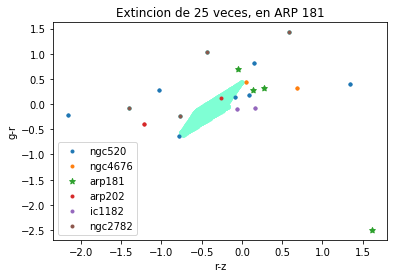

In [10]:
os.listdir('Magnitud/Instantaneas/Tidal 11') #tidal-output: 11-2, 12-3, 13-4, 14-5, 15-6, 16-7, 17-8, 18-3
Tidal=12
output=3
route_u=f'Magnitud/Instantaneas/Tidal {Tidal}/U_Seba_output {output}.txt'
route_g=f'Magnitud/Instantaneas/Tidal {Tidal}/G_Seba_output {output}.txt'
route_r=f'Magnitud/Instantaneas/Tidal {Tidal}/R_Seba_output {output}.txt'
route_i=f'Magnitud/Instantaneas/Tidal {Tidal}/I_Seba_output {output}.txt'
route_z=f'Magnitud/Instantaneas/Tidal {Tidal}/Z_Seba_output {output}.txt'

u=ascii.read(route_u)
g=ascii.read(route_g)
r=ascii.read(route_r)
i=ascii.read(route_i)
z=ascii.read(route_z)

ug = u['Magnitud']-g['Magnitud']
gr = g['Magnitud']-r['Magnitud']
gz = g['Magnitud']-z['Magnitud']
ri = r['Magnitud']-i['Magnitud']
iz = i['Magnitud']-z['Magnitud']
rz = r['Magnitud']-z['Magnitud']
ur = u['Magnitud']-r['Magnitud']

#en funcion de la extincion:
u_ext = [U['Magnitud']+float(ext[0]) for U in u] #1 extincion
g_ext = [G['Magnitud']+float(ext[1]) for G in g] #1 extincion
r_ext = [R['Magnitud']+float(ext[2]) for R in r] #1 extincion
i_ext = [I['Magnitud']+float(ext[3]) for I in i] #1 extincion
z_ext = [Z['Magnitud']+float(ext[4]) for Z in z] #1 extincion

ug_ext = [a-b for a,b in zip(u_ext,g_ext)]
gr_ext = [a-b for a,b in zip(g_ext,r_ext)]
gz_ext = [a-b for a,b in zip(g_ext,z_ext)]
ri_ext = [a-b for a,b in zip(r_ext,i_ext)]
rz_ext = [a-b for a,b in zip(r_ext,z_ext)]
ur_ext = [a-b for a,b in zip(u_ext,r_ext)]

#N cantidad de extinciones:
Numero = 0
while Numero == 0:
    try:
        Numero = int(input('Number of replications >'))
    except(valueError):
        pass

u_multi_ext = extinctions(u,ext[0],Numero)
g_multi_ext = extinctions(g,ext[1],Numero)
r_multi_ext = extinctions(r,ext[2],Numero)
i_multi_ext = extinctions(i,ext[3],Numero)
z_multi_ext = extinctions(z,ext[4],Numero)

ug_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(u_multi_ext,g_multi_ext)]
gr_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(g_multi_ext,r_multi_ext)]
gz_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(g_multi_ext,z_multi_ext)]
ri_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(r_multi_ext,i_multi_ext)]
rz_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(r_multi_ext,z_multi_ext)]
ur_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(u_multi_ext,r_multi_ext)]

color_candidatos = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
#graficando
for gr,rz,col,name in zip(resta_gr,resta_rz,color_candidatos,names): #data fotometrica canidatos confirmados, para "legend"
    if name == f'{extra[tipo].lower()}{R}':
        plt.scatter(rz,gr,marker='*', c=col )
    else:
        plt.scatter(rz,gr,marker='.', c=col )
    
plt.legend(names)

plt.scatter(rz,gr,marker='.',color='cyan') #modelo

if Numero > 0:
    for val in range(Numero):
        plt.scatter(rz_multi_ext[val],gr_multi_ext[val],marker='.',color='aquamarine')
        
if Numero < 0:
    Numero = round((Numero**2)**(1/2))
    for val in range(Numero):
        plt.scatter(rz_multi_ext[val],gr_multi_ext[val],marker='.',color='aquamarine')

if Numero == 0:
    pass

for gr,rz,col in zip(resta_gr,resta_rz,color_candidatos): #repeticion de data fotometrica canidatos confirmados, para visualizacion
    if name == f'{extra[tipo].lower()}{R}':
        plt.scatter(rz,gr,marker='*', c=col )
    else:
        plt.scatter(rz,gr,marker='.', c=col )


#plt.scatter(rz_hcg,gr_hcg,marker='.',color='g')
plt.title(f'Extincion de {Numero} veces, en {extra[tipo]} {R}')
plt.xlabel('r-z')
plt.ylabel('g-r')
#plt.xlim(-1,-0.5)
#plt.ylim(-1,0)

plt.show()

In [11]:
(resta_rz),resta_gr
max(gr_multi_ext[len(gr_multi_ext)-1])

0.43853766867537836

In [12]:
#Determinar distancias por cumulo
#CHI^2 para mejor ajuste de edad -> marcador de edad
#Determinar mejor vector u*sqrt(2) de distancia
#Comparar mejor vector de distancia en cada simulacion (6) con datos fotometricos
#determinar cantidad de candidatos (cantidad por cumulo)


In [13]:
###### determinacion valores distancia #tidal-output: 11-2, 12-3, 13-4, 14-5, 15-6, 16-7, 17-8, 18-3
Tidals = [10,11,12,16,17,18]
Outputs = ['',2,3,7,8,3]
routes_u = [f'Magnitud/Instantaneas/Tidal {Tidal}/U_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_g = [f'Magnitud/Instantaneas/Tidal {Tidal}/G_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_r = [f'Magnitud/Instantaneas/Tidal {Tidal}/R_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_i = [f'Magnitud/Instantaneas/Tidal {Tidal}/I_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_z = [f'Magnitud/Instantaneas/Tidal {Tidal}/Z_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]

tablas_u = [ascii.read(route_u) for route_u in routes_u] #tablas magnitud simulaciones
tablas_g = [ascii.read(route_g) for route_g in routes_g]
tablas_r = [ascii.read(route_r) for route_r in routes_r]
tablas_i = [ascii.read(route_i) for route_i in routes_i]
tablas_z = [ascii.read(route_z) for route_z in routes_z]

ug_general = [u['Magnitud']-g['Magnitud'] for u,g in zip(tablas_u,tablas_g)] 
gr_general = [g['Magnitud']-r['Magnitud'] for g,r in zip(tablas_g,tablas_r)]
gz_general = [g['Magnitud']-z['Magnitud'] for g,z in zip(tablas_g,tablas_z)]
ri_general = [r['Magnitud']-i['Magnitud'] for r,i in zip(tablas_r,tablas_i)]
iz_general = [i['Magnitud']-z['Magnitud'] for i,z in zip(tablas_i,tablas_z)]
rz_general = [r['Magnitud']-z['Magnitud'] for r,z in zip(tablas_r,tablas_z)]
ur_general = [u['Magnitud']-r['Magnitud'] for u,r in zip(tablas_u,tablas_r)]

edades = [age for age in range(100,1000+1,5)]
#Extinciones por data confirmada:
all_routes = ['Candidatos/Extincion_candidatos/extinctions_ARP_181.csv','Candidatos/Extincion_candidatos/extinctions_ARP_202.csv','Candidatos/Extincion_candidatos/extinctions_NGC_520.csv','Candidatos/Extincion_candidatos/extinctions_IC_1182.csv','Candidatos/Extincion_candidatos/extinctions_NGC_2782.csv','Candidatos/Extincion_candidatos/extinctions_NGC_4676.csv']
all_tables = [ascii.read(path) for path in all_routes]
all_extinctions = [table['The Galactic extinction'] for table in all_tables] #todas las extinciones

#N cantidad de extinciones:
Numero = ''
while Numero == '':
    try:
        Numero = int(input('Number of replications >'))
    except(valueError):
        pass


for ext in all_extinctions:
    all_u_multi_ext = [extinctions(u,ext[0],Numero) for u in tablas_u] #una extincion sobre cada tabla
    all_g_multi_ext = [extinctions(g,ext[1],Numero) for g in tablas_g]
    all_r_multi_ext = [extinctions(r,ext[2],Numero) for r in tablas_r]
    all_i_multi_ext = [extinctions(i,ext[3],Numero) for i in tablas_i]
    all_z_multi_ext = [extinctions(z,ext[4],Numero) for z in tablas_z]
    
    all_u_ext = [parametro_extincion(u,ext[0],Numero) for u in tablas_u] #una extincion sobre cada tabla
    all_g_ext = [parametro_extincion(g,ext[1],Numero) for g in tablas_g]
    all_r_ext = [parametro_extincion(r,ext[2],Numero) for r in tablas_r]
    all_i_ext = [parametro_extincion(i,ext[3],Numero) for i in tablas_i]
    all_z_ext = [parametro_extincion(z,ext[4],Numero) for z in tablas_z]


all_ug_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_multi_ext,all_g_multi_ext)]
all_gr_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_multi_ext,all_r_multi_ext)]
all_gz_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_multi_ext,all_z_multi_ext)]
all_ri_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_multi_ext,all_i_multi_ext)]
all_rz_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_multi_ext,all_z_multi_ext)]
all_ur_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_multi_ext,all_r_multi_ext)]

all_ug_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_ext,all_g_ext)]
all_gr_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_ext,all_r_ext)]
all_gz_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_ext,all_z_ext)]
all_ri_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_ext,all_i_ext)]
all_rz_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_ext,all_z_ext)]
all_ur_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_ext,all_r_ext)]
#cada par de colores me entrega un punto (coordennadas), simulacion

X_confirmado = []
Y_confirmado = []
for a,b,name in zip(resta_gr,resta_rz,names): #datos confirmado: filtro por tipo unico
    #if f'{extra[tipo].lower()}{R}'==name:
    aux = []
    aux2 = []
    for m,n in zip(a,b):
        aux.append(m)
        aux2.append(n)
    X_confirmado.append(aux) #largo 6 por los tipos
    Y_confirmado.append(aux2)

X_simulation = []
Y_simulation = []
X_extincion = []
Y_extincion = []
ID_edad = []
indice_simulacion = []
for a,b,ae,be in zip(all_gr_multi_ext,all_rz_multi_ext,all_gr_ext,all_rz_ext):
    gr_ind = all_gr_multi_ext.index(a) #indice de la simulacion
    rz_ind = all_rz_multi_ext.index(b)
    for m,n,me,ne in zip(a,b,ae,be):
        for x,y,xe,ye,age in zip(m,n,me,ne,edades):
            X_simulation.append(x)
            Y_simulation.append(y)
            X_extincion.append(xe)
            Y_extincion.append(ye)
            ID_edad.append(age)
            indice_simulacion.append([gr_ind,rz_ind])
            
all_chi = []
for coord_x_real_list,coord_y_real_list,name in zip(X_confirmado,Y_confirmado,names):
    por_confirmado = []
    for coord_x_real,coord_y_real in zip(coord_x_real_list,coord_y_real_list):
        point_real_aux = [coord_x_real,coord_y_real]
        alpha = []
        for coord_x_sim,coord_y_sim,coord_x_extincion,coord_y_extincion,age,ID in zip(X_simulation,Y_simulation,X_extincion,Y_extincion,ID_edad,indice_simulacion):
            point_sim_aux = [coord_x_sim,coord_y_sim]
            c2 = chi2(point_real_aux,point_sim_aux) 
            alpha.append([c2,age,name,ID,point_real_aux,point_sim_aux,round(coord_x_extincion,5),round(coord_y_extincion,5)])#chi2,edad,grupo,id,punto_real,punto_simulado, extincion gr, extincion rz
        por_confirmado.append(alpha)
    all_chi.append(por_confirmado)

new_out = []
for chis,nam in zip(all_chi,names):
    for chi in chis:
        
        new_out.append(min(chi)) #mejor ajuste por punto
print('Ready to go!')

Number of replications >25
Ready to go!


In [14]:
#chi2:0 , edad:1, grupo:2, id:3, punto_real:4, punto_simulado:5 , extinciones: 6 y 7
Save = Table()

chi2_ =[]
edad_ =[]
grupo_ =[]
id_simulacion_ =[]
punto_real_x =[]
punto_real_y =[]
punto_simulado_x =[]
punto_simulado_y =[]
extincion_x = []
extincion_y = []
for data2 in new_out:
    chi2_.append(data2[0])
    edad_.append(data2[1])
    grupo_.append(data2[2])
    id_simulacion_.append(data2[3][0])
    punto_real_x.append(data2[4][0])
    punto_real_y.append(data2[4][1])
    punto_simulado_x.append(data2[5][0])
    punto_simulado_y.append(data2[5][1])
    extincion_x.append(data2[6])
    extincion_y.append(data2[7])

Save['Grupo'] = grupo_
Save['ID'] = id_simulacion_
Save['Edad'] = edad_
Save['Chi2'] = chi2_
Save['gr Real'] = punto_real_x
Save['rz Real'] = punto_real_y
Save['gr Simulado'] = punto_simulado_x
Save['rz Simulado'] = punto_simulado_y
Save['gr extincion'] = extincion_x
Save['rz extincion'] = extincion_y
Save.show_in_notebook()

idx,Grupo,ID,Edad,Chi2,gr Real,rz Real,gr Simulado,rz Simulado,gr extincion,rz extincion
0,ngc520,3,140,1.0427942935505318e-06,-0.631,-0.776,-0.5910725693965198,-0.8055615681854711,0.034,0.034
1,ngc520,3,100,1.0293031199249177e-06,0.276,-1.034,-0.6573201753968831,-0.8432187859923559,0.017,0.017
2,ngc520,3,100,0.09977510584825808,0.394,1.339,-0.6573201753968831,-0.8432187859923559,0.017,0.017
3,ngc520,2,110,2.0512678863579994e-09,0.825,0.148,-0.5296582748684671,-0.6495549296001784,0.102,0.102
4,ngc520,3,100,1.1433349375455026,-0.226,-2.163,-0.6573201753968831,-0.8432187859923559,0.017,0.017
5,ngc520,2,630,0.03453229756059122,0.136,-0.092,0.10525690548975142,-0.23633538735085757,0.425,0.425
6,ngc520,2,630,0.014805455002013712,0.178,0.084,0.10525690548975142,-0.23633538735085757,0.425,0.425
7,ngc4676,5,220,3.5014474908115615e-10,0.44,0.05,-0.20305346657942103,-0.39354836857399356,0.391,0.391
8,ngc4676,0,435,4.515406210764036e-09,0.319,0.679,-0.38546135977824036,-0.6436682943938425,0.136,0.136
9,arp181,4,645,5.015346688683469e-10,0.702,-0.051,-0.29288624684719977,-0.6399970301735305,0.017,0.017


In [15]:
for id_ in Save['ID']:
    print(f'Tidal:{Tidals[id_]} Output: {Outputs[id_]}')

Tidal:16 Output: 7
Tidal:16 Output: 7
Tidal:16 Output: 7
Tidal:12 Output: 3
Tidal:16 Output: 7
Tidal:12 Output: 3
Tidal:12 Output: 3
Tidal:18 Output: 3
Tidal:10 Output: 
Tidal:17 Output: 8
Tidal:16 Output: 7
Tidal:18 Output: 3
Tidal:16 Output: 7
Tidal:16 Output: 7
Tidal:12 Output: 3
Tidal:12 Output: 3
Tidal:12 Output: 3
Tidal:16 Output: 7
Tidal:18 Output: 3
Tidal:16 Output: 7
Tidal:16 Output: 7


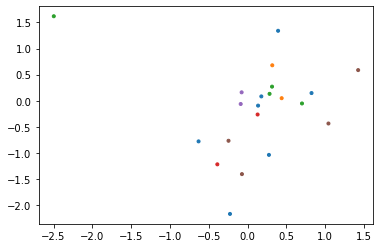

In [16]:
color_candidatos = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
col_group = []
for fil in Save:
    for col,nam in zip(color_candidatos,names):
        if fil['Grupo'] == nam:
            col_group.append(col)
Save['Color'] = col_group
plt.scatter(Save['gr Real'],Save['rz Real'],marker='.',c=Save['Color'])

plt.show()

In [17]:
#distancia
distance = np.sqrt((Save['gr Real']-Save['gr Simulado'])**2+(Save['rz Real']-Save['rz Simulado'])**2)
Save['Vector u'] = distance
Save.show_in_notebook()

idx,Grupo,ID,Edad,Chi2,gr Real,rz Real,gr Simulado,rz Simulado,gr extincion,rz extincion,Color,Vector u
0,ngc520,3,140,1.0427942935505318e-06,-0.631,-0.776,-0.5910725693965198,-0.8055615681854711,0.034,0.034,#1f77b4,0.049679835226981044
1,ngc520,3,100,1.0293031199249177e-06,0.276,-1.034,-0.6573201753968831,-0.8432187859923559,0.017,0.017,#1f77b4,0.95261955754703
2,ngc520,3,100,0.09977510584825808,0.394,1.339,-0.6573201753968831,-0.8432187859923559,0.017,0.017,#1f77b4,2.4222619472580758
3,ngc520,2,110,2.0512678863579994e-09,0.825,0.148,-0.5296582748684671,-0.6495549296001784,0.102,0.102,#1f77b4,1.5720028331396723
4,ngc520,3,100,1.1433349375455026,-0.226,-2.163,-0.6573201753968831,-0.8432187859923559,0.017,0.017,#1f77b4,1.388473819181294
5,ngc520,2,630,0.03453229756059122,0.136,-0.092,0.10525690548975142,-0.23633538735085757,0.425,0.425,#1f77b4,0.14757317473642753
6,ngc520,2,630,0.014805455002013712,0.178,0.084,0.10525690548975142,-0.23633538735085757,0.425,0.425,#1f77b4,0.3284909712429718
7,ngc4676,5,220,3.5014474908115615e-10,0.44,0.05,-0.20305346657942103,-0.39354836857399356,0.391,0.391,#ff7f0e,0.781186863781299
8,ngc4676,0,435,4.515406210764036e-09,0.319,0.679,-0.38546135977824036,-0.6436682943938425,0.136,0.136,#ff7f0e,1.498571728151617
9,arp181,4,645,5.015346688683469e-10,0.702,-0.051,-0.29288624684719977,-0.6399970301735305,0.017,0.017,#2ca02c,1.1561644111971905


In [18]:
for fil in Save:
    if fil['Vector u'] == max(Save['Vector u']):
        print(fil)

Grupo   ID Edad        Chi2        gr Real rz Real     gr Simulado         rz Simulado     gr extincion rz extincion  Color       Vector u     
------ --- ---- ------------------ ------- ------- ------------------- ------------------- ------------ ------------ ------- ------------------
arp181   3  100 3.3967638872776695  -2.497   1.617 -0.6573201753968831 -0.8432187859923559        0.017        0.017 #2ca02c 3.0719860566092185


In [19]:
Save['N factor gr'] = [round(i/0.017,5) for i in (Save['gr extincion'])]
Save['N factor rz'] = [round(i/0.017,5) for i in (Save['rz extincion'])]
Save.show_in_notebook()

idx,Grupo,ID,Edad,Chi2,gr Real,rz Real,gr Simulado,rz Simulado,gr extincion,rz extincion,Color,Vector u,N factor gr,N factor rz
0,ngc520,3,140,1.0427942935505318e-06,-0.631,-0.776,-0.5910725693965198,-0.8055615681854711,0.034,0.034,#1f77b4,0.049679835226981044,2.0,2.0
1,ngc520,3,100,1.0293031199249177e-06,0.276,-1.034,-0.6573201753968831,-0.8432187859923559,0.017,0.017,#1f77b4,0.95261955754703,1.0,1.0
2,ngc520,3,100,0.09977510584825808,0.394,1.339,-0.6573201753968831,-0.8432187859923559,0.017,0.017,#1f77b4,2.4222619472580758,1.0,1.0
3,ngc520,2,110,2.0512678863579994e-09,0.825,0.148,-0.5296582748684671,-0.6495549296001784,0.102,0.102,#1f77b4,1.5720028331396723,6.0,6.0
4,ngc520,3,100,1.1433349375455026,-0.226,-2.163,-0.6573201753968831,-0.8432187859923559,0.017,0.017,#1f77b4,1.388473819181294,1.0,1.0
5,ngc520,2,630,0.03453229756059122,0.136,-0.092,0.10525690548975142,-0.23633538735085757,0.425,0.425,#1f77b4,0.14757317473642753,25.0,25.0
6,ngc520,2,630,0.014805455002013712,0.178,0.084,0.10525690548975142,-0.23633538735085757,0.425,0.425,#1f77b4,0.3284909712429718,25.0,25.0
7,ngc4676,5,220,3.5014474908115615e-10,0.44,0.05,-0.20305346657942103,-0.39354836857399356,0.391,0.391,#ff7f0e,0.781186863781299,23.0,23.0
8,ngc4676,0,435,4.515406210764036e-09,0.319,0.679,-0.38546135977824036,-0.6436682943938425,0.136,0.136,#ff7f0e,1.498571728151617,8.0,8.0
9,arp181,4,645,5.015346688683469e-10,0.702,-0.051,-0.29288624684719977,-0.6399970301735305,0.017,0.017,#2ca02c,1.1561644111971905,1.0,1.0


In [20]:
identificador_sim = [ind for ind in sorted(unique(Save['ID']))]
agrupaciones = [[] for ind in identificador_sim]
for agr,id_ in zip(agrupaciones,identificador_sim):
    for line in Save:
        if id_ == line['ID']:
            agr.append(np.sqrt((line['N factor gr']**2)+(line['N factor rz']**2)))
agrupaciones  

[[11.313708498984761],
 [8.48528137423857,
  35.35533905932738,
  35.35533905932738,
  31.11269837220809,
  35.35533905932738,
  35.35533905932738],
 [2.8284271247461903,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  33.94112549695428,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951],
 [1.4142135623730951],
 [32.526911934581186, 18.384776310850235, 9.899494936611665]]

In [21]:
jk = []
for g,r,z in zip(all_g_ext,all_r_ext,all_z_ext):
    for eg,er,ez in zip(g,r,z):
        for ge,re,ze in zip(eg,er,ez):

            jk.append(((round(re-ze,5))))
#unique(jk)
#sorted(Save['N factor gr'])
#all_extinctions

In [22]:
#[edades[edades.index(i)] for i in Save['Edad']]
#all_hcg_extinction_tables


In [23]:

N = [max([round(w/np.sqrt(2),5) for w in i]) for i in agrupaciones] #factor N por simulacion.
N,identificador_sim
#N = [30,30,30,30,30,30]

([8.0, 25.0, 24.0, 1.0, 23.0], [0, 2, 3, 4, 5])

In [24]:
N

[8.0, 25.0, 24.0, 1.0, 23.0]

In [25]:
os.listdir('Extinction')

['extinctions_hcg_96.csv',
 'extinctions_hcg_100.csv',
 'extinctions_hcg_22.csv',
 'extinctions_hcg_31.csv',
 'extinctions_hcg_26.csv',
 'extinctions_hcg_16.csv',
 'extinctions_hcg_2.csv',
 'extinctions_hcg_7.csv',
 'extinctions_hcg_6.csv',
 'extinctions_hcg_89.csv']

In [26]:
#hcg
all_hcg_base_route = 'Mag_hcg_600/Magnitudes hcg '
all_hcg_numbers = [2,6,7,16,22,26,31,89,96,100]
all_hcg_tables = [ascii.read(f'{all_hcg_base_route}{nmbr}') for nmbr in all_hcg_numbers]

g_hcg_tables = [table['m_g'] for table in all_hcg_tables]
r_hcg_tables = [table['m_r'] for table in all_hcg_tables]
z_hcg_tables = [table['m_z'] for table in all_hcg_tables]
#ra_hcg_tables = [table['ra'] for table in all_hcg_tables]
#dec_hcg_tables = [table['dec'] for table in all_hcg_tables]

gr_hcg_tables = [g-r for g,r in zip(g_hcg_tables,r_hcg_tables)]
rz_hcg_tables = [r-z for r,z in zip(r_hcg_tables,z_hcg_tables)]

#for a,b in zip(rz_hcg_tables,gr_hcg_tables):
#    plt.scatter(a,b,marker='.')
#plt.show()

#eleccion de modelo simulado


#extincion hcg
all_hcg_extinction_base_route = 'Extinction/extinctions_hcg_'
all_hcg_extinction_tables = [(ascii.read(f'{all_hcg_extinction_base_route}{nmbr}.csv'))['The Galactic extinction'] for nmbr in all_hcg_numbers]

for ext in all_hcg_extinction_tables: #una extincion sobre cada tabla; ext[0]=u,ext[1]=g,ext[2]=r,ext[3]=i,ext[4]=z
    #print(len([extinctions(g,ext[1],int(n)) for g,n in zip(tablas_g,N)]))
    all_g_hcg_ext = [extinctions(g,ext[1],int(n)) for g,n in zip(tablas_g,N)]
    all_r_hcg_ext = [extinctions(r,ext[2],int(n)) for r,n in zip(tablas_r,N)]
    all_z_hcg_ext = [extinctions(z,ext[4],int(n)) for z,n in zip(tablas_z,N)]
    

all_gr_hcg_ext = [[[g-r for g,r in zip(ge,re)] for ge,re in zip(eg,er)] for eg,er in zip(all_g_hcg_ext,all_r_hcg_ext)]
all_rz_hcg_ext = [[[r-z for r,z in zip(re,ze)] for re,ze in zip(er,ez)] for er,ez in zip(all_r_hcg_ext,all_z_hcg_ext)]

invalid value encountered in subtract


In [33]:
ruta_catalogo = ('Mag_hcg_600/Catálogo hcg hcg 100')
hcg_100 = ascii.read(ruta_catalogo)
g_hcg100_tables = [table['m_g'] for table in hcg_100]
r_hcg100_tables = [table['m_r'] for table in hcg_100]
z_hcg100_tables = [table['m_z'] for table in hcg_100]
ra_hcg100_tables = [table['ra'] for table in hcg_100]
dec_hcg100_tables = [table['dec'] for table in hcg_100]
ext_100 = [table['ebv'] for table in hcg_100]

all_hcg100_ext = 'Extinction/extinctions_hcg_100.csv'
all_hcg100_extinction_tables = (ascii.read(all_hcg100_ext))['The Galactic extinction']


for ext in all_hcg100_extinction_tables: #una extincion sobre cada tabla; ext[0]=u,ext[1]=g,ext[2]=r,ext[3]=i,ext[4]=z
    if ext==all_hcg_extinction_tables[1] or ext==all_hcg_extinction_tables[2] or ext==all_hcg_extinction_tables[4]:
        all_g_hcg100_ext = [extinctions(g,ext,int(n)) for g,n in zip(tablas_g,N)]
        all_r_hcg100_ext = [extinctions(r,ext,int(n)) for r,n in zip(tablas_r,N)]
        all_z_hcg100_ext = [extinctions(z,ext,int(n)) for z,n in zip(tablas_z,N)]
    
gr_hcg100_tables = [g-r for g,r in zip(g_hcg100_tables,r_hcg100_tables)]
rz_hcg100_tables = [r-z for r,z in zip(r_hcg100_tables,z_hcg100_tables)]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [28]:
for i,j in zip(all_gr_hcg_ext,all_rz_hcg_ext):
    print(max(max(i)),max(max(j)))

0.3454286814097678 -0.0023737460274393385
1.860232437407901 1.4531476970090038
1.85553766867538 1.4151007002905107
-0.23557035131955573 -0.5833747082676997
1.77253773935945 1.3321005945403233


In [29]:
a=rz_hcg_tables[4]
b=gr_hcg_tables[4]


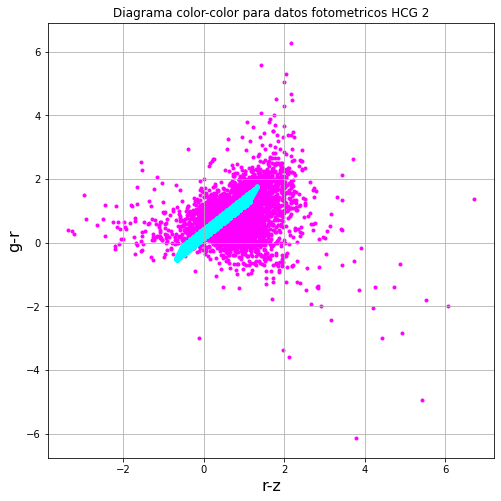

In [30]:
a=rz_hcg_tables[0]
b=gr_hcg_tables[0]

plt.figure(figsize=(8,8))
plt.title('Diagrama color-color para datos fotometricos HCG 2')
#for i,j in zip((all_rz_hcg_ext),(all_gr_hcg_ext)):

plt.grid()  
plt.scatter(a,b,marker='.',color='magenta')
plt.scatter(all_rz_hcg_ext[4],all_gr_hcg_ext[4],marker='.',c='cyan')
plt.xlabel('r-z',fontsize=16)
plt.ylabel('g-r',fontsize=16)
#plt.xlim(-1,2)
#plt.ylim(-1,2)
plt.savefig('hcg2.png',format='png')
plt.show()

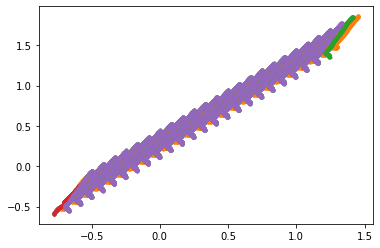

In [31]:

for i,j,co in zip((all_rz_hcg_ext),(all_gr_hcg_ext),color_candidatos):
    plt.scatter(i,j,marker='.',c=co)
plt.show()

In [35]:
hcg = [2,6,7,16,22,26,31,89,96,100]

In [36]:
#Paso 1: reconocer limites en eje g-r y comenzar evaluacion sobre valores unicos
#Paso 2: Evaluacion: reconocimiento de valores minimos y maximos r-z en un determinado g-r
#Paso 3: ¿Las coordenadas estan dentro de estos limites?
    #Paso 3, si: Guardar coordenadas (g-r,r-z) en nueva disposicion, guardado como valor valido
    #Paso 3, no: Pasar del valor, valor invalido
#Paso 4: Contar total de valores de coinciden en el area continua

###No evaluar mejor ajuste en estos, solo si es candidato o no -> Estudios futuros permiten determinar mejor
###Ver si se pueden conseguir DEC y RA de los objetos para caracterizarlos por tabla, por grupo compacto.



In [37]:
a=rz_hcg100_tables
b=gr_hcg100_tables

LT_hcg100 = Table()


LT_hcg100[f'hcg 100 gr'] = a
LT_hcg100[f'hcg 100 rz'] = b
LT_hcg100[f'hcg 100 ra'] = ra_hcg100_tables
LT_hcg100[f'hcg 100 dec'] = dec_hcg100_tables
LT_hcg100

NameError: name 'rz_hcg100_tables' is not defined

In [38]:
plt.scatter(LT_hcg100['hcg 100 rz'],LT_hcg100['hcg 100 gr'], marker='.')
plt.show()

NameError: name 'LT_hcg100' is not defined

In [39]:
#Datos por hcg por tabla, sin filtrar
a=rz_hcg_tables
b=gr_hcg_tables

LT_hcg = [Table() for i in hcg]
for rz,gr,HCG,tab in zip(a,b,hcg,LT_hcg):

    tab[f'hcg {HCG} gr'] = gr
    tab[f'hcg {HCG} rz'] = rz


In [40]:
len(all_rz_hcg_ext)

5

In [41]:
for i in all_rz_hcg_ext:
    print(len(i))

8
25
24
1
23


In [42]:
###### determinacion valores distancia #tidal-output: 11-2, 12-3, 13-4, 14-5, 15-6, 16-7, 17-8, 18-3
Tidals = [10,11,12,16,17,18]
Outputs = ['',2,3,7,8,3]
routes_u = [f'Magnitud/Instantaneas/Tidal {Tidal}/U_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_g = [f'Magnitud/Instantaneas/Tidal {Tidal}/G_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_r = [f'Magnitud/Instantaneas/Tidal {Tidal}/R_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_i = [f'Magnitud/Instantaneas/Tidal {Tidal}/I_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_z = [f'Magnitud/Instantaneas/Tidal {Tidal}/Z_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]

tablas_u = [ascii.read(route_u) for route_u in routes_u] #tablas magnitud
tablas_g = [ascii.read(route_g) for route_g in routes_g]
tablas_r = [ascii.read(route_r) for route_r in routes_r]
tablas_i = [ascii.read(route_i) for route_i in routes_i]
tablas_z = [ascii.read(route_z) for route_z in routes_z]

ug_general = [u['Magnitud']-g['Magnitud'] for u,g in zip(tablas_u,tablas_g)] 
gr_general = [g['Magnitud']-r['Magnitud'] for g,r in zip(tablas_g,tablas_r)]
gz_general = [g['Magnitud']-z['Magnitud'] for g,z in zip(tablas_g,tablas_z)]
ri_general = [r['Magnitud']-i['Magnitud'] for r,i in zip(tablas_r,tablas_i)]
iz_general = [i['Magnitud']-z['Magnitud'] for i,z in zip(tablas_i,tablas_z)]
rz_general = [r['Magnitud']-z['Magnitud'] for r,z in zip(tablas_r,tablas_z)]
ur_general = [u['Magnitud']-r['Magnitud'] for u,r in zip(tablas_u,tablas_r)]

edades = [age for age in range(100,1000+1,5)]
#Extinciones por data confirmada:
all_routes = ['Candidatos/Extincion_candidatos/extinctions_ARP_181.csv','Candidatos/Extincion_candidatos/extinctions_ARP_202.csv','Candidatos/Extincion_candidatos/extinctions_NGC_520.csv','Candidatos/Extincion_candidatos/extinctions_IC_1182.csv','Candidatos/Extincion_candidatos/extinctions_NGC_2782.csv','Candidatos/Extincion_candidatos/extinctions_NGC_4676.csv']
all_tables = [ascii.read(path) for path in all_routes]
all_extinctions = [table['The Galactic extinction'] for table in all_tables] #todas las extinciones

#N cantidad de extinciones:
Numero = ''
while Numero == '':
    try:
        Numero = int(input('Number of replications >'))
    except(valueError):
        pass


for ext in all_extinctions:
    all_u_multi_ext = [extinctions(u,ext[0],Numero) for u in tablas_u] #una extincion sobre cada tabla
    all_g_multi_ext = [extinctions(g,ext[1],Numero) for g in tablas_g]
    all_r_multi_ext = [extinctions(r,ext[2],Numero) for r in tablas_r]
    all_i_multi_ext = [extinctions(i,ext[3],Numero) for i in tablas_i]
    all_z_multi_ext = [extinctions(z,ext[4],Numero) for z in tablas_z]
    
    all_u_ext = [parametro_extincion(u,ext[0],Numero) for u in tablas_u] #una extincion sobre cada tabla
    all_g_ext = [parametro_extincion(g,ext[1],Numero) for g in tablas_g]
    all_r_ext = [parametro_extincion(r,ext[2],Numero) for r in tablas_r]
    all_i_ext = [parametro_extincion(i,ext[3],Numero) for i in tablas_i]
    all_z_ext = [parametro_extincion(z,ext[4],Numero) for z in tablas_z]


all_ug_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_multi_ext,all_g_multi_ext)]
all_gr_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_multi_ext,all_r_multi_ext)]
all_gz_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_multi_ext,all_z_multi_ext)]
all_ri_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_multi_ext,all_i_multi_ext)]
all_rz_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_multi_ext,all_z_multi_ext)]
all_ur_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_multi_ext,all_r_multi_ext)]

all_ug_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_ext,all_g_ext)]
all_gr_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_ext,all_r_ext)]
all_gz_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_ext,all_z_ext)]
all_ri_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_ext,all_i_ext)]
all_rz_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_ext,all_z_ext)]
all_ur_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_ext,all_r_ext)]
#cada par de colores me entrega un punto (coordennadas), simulacion

X_confirmado = []
Y_confirmado = []
for a,b,name in zip(resta_gr,resta_rz,names): #datos confirmado: filtro por tipo unico
    #if f'{extra[tipo].lower()}{R}'==name:
    aux = []
    aux2 = []
    for m,n in zip(a,b):
        aux.append(m)
        aux2.append(n)
    X_confirmado.append(aux) #largo 6 por los tipos
    Y_confirmado.append(aux2)

X_simulation = []
Y_simulation = []
X_extincion = []
Y_extincion = []
ID_edad = []
indice_simulacion = []
for a,b,ae,be in zip(all_gr_multi_ext,all_rz_multi_ext,all_gr_ext,all_rz_ext):
    gr_ind = all_gr_multi_ext.index(a) #indice de la simulacion
    rz_ind = all_rz_multi_ext.index(b)
    for m,n,me,ne in zip(a,b,ae,be):
        for x,y,xe,ye,age in zip(m,n,me,ne,edades):
            X_simulation.append(x)
            Y_simulation.append(y)
            X_extincion.append(xe)
            Y_extincion.append(ye)
            ID_edad.append(age)
            indice_simulacion.append([gr_ind,rz_ind])
            
all_chi = []
for coord_x_real_list,coord_y_real_list,name in zip(X_confirmado,Y_confirmado,names):
    por_confirmado = []
    for coord_x_real,coord_y_real in zip(coord_x_real_list,coord_y_real_list):
        point_real_aux = [coord_x_real,coord_y_real]
        alpha = []
        for coord_x_sim,coord_y_sim,coord_x_extincion,coord_y_extincion,age,ID in zip(X_simulation,Y_simulation,X_extincion,Y_extincion,ID_edad,indice_simulacion):
            point_sim_aux = [coord_x_sim,coord_y_sim]
            c2 = chi2(point_real_aux,point_sim_aux) 
            alpha.append([c2,age,name,ID,point_real_aux,point_sim_aux,round(coord_x_extincion,5),round(coord_y_extincion,5)])#chi2,edad,grupo,id,punto_real,punto_simulado, extincion gr, extincion rz
        por_confirmado.append(alpha)
    all_chi.append(por_confirmado)

new_out = []
for chis,nam in zip(all_chi,names):
    for chi in chis:
        
        new_out.append(min(chi)) #mejor ajuste por punto
print('Ready to go!')

Number of replications >25
Ready to go!


In [43]:
lim_gr = []
lim_rz = []
for gr_,rz_ in zip(all_gr_hcg_ext,all_rz_hcg_ext):
    lim_gr.append(limites(gr_))
    lim_rz.append(limites(rz_))
lim_rz

[[-0.7772179018007854, -0.0023737460274393385],
 [-0.7273089165478055, 1.4531476970090038],
 [-0.6969629762913438, 1.4151007002905107],
 [-0.7772187859923569, -0.5833747082676997],
 [-0.696962585769894, 1.3321005945403233]]

In [44]:
hcg100_gr = []
hcg100_rz = [] 
ra_hcg100 = []
dec_hcg100 = []
for g,z,ra,dec in zip(gr_hcg100_tables,rz_hcg100_tables,ra_hcg100_tables,dec_hcg100_tables):
    combg = []
    combz = []
    
    combra = []
    combdec = []
    #print(g,z,ra,dec)

    for limg,limz in zip(lim_gr,lim_rz):
        auxgr=[]
        auxrz=[]
        auxra = []
        auxdec = []

        if g>=limg[0] and g <=limg[1] and z>=limz[0] and z <=limz[1]:
            auxgr.append(g)
            auxrz.append(z)
            auxra.append(ra)
            auxdec.append(dec)
        combg.append(auxgr)
        combz.append(auxrz)
        combra.append(auxra)
        combdec.append(auxdec)
    hcg100_gr.append(combg)
    hcg100_rz.append(combz)
    ra_hcg100.append(combra)
    dec_hcg100.append(combdec)


NameError: name 'gr_hcg100_tables' is not defined

In [45]:
#limites para rectangulo -> puntos para regresiones
simulaciones_hcg_ext_maximos = (extremos(all_rz_hcg_ext,all_gr_hcg_ext)[0]) #puntos de limites sup e inf de los modelos
simulaciones_hcg_ext_minimos = (extremos(all_rz_hcg_ext,all_gr_hcg_ext)[1]) #para regresion

simulaciones_base = [[(l,l2) for l,l2 in zip(lista[0],lista2[0])] for lista,lista2 in zip(all_rz_hcg_ext,all_gr_hcg_ext)] #limites horizontales para regresion
simulaciones_finales = [[(l,l2) for l,l2 in zip(lista[len(lista)-1],lista2[len(lista2)-1])] for lista,lista2 in zip(all_rz_hcg_ext,all_gr_hcg_ext)]

In [46]:
dist = []
for a,b in zip(simulaciones_base,simulaciones_finales):
    for a2,b2 in zip(a,b):
        x2 = ((b2[0])-(a2[0]))**2
        y2 = ((b2[1])-(a2[1]))**2
        
        dist.append(np.sqrt(x2+y2))
v=1
r=[]
out5=[]
for i in dist:
    
    if v%181==0:
        out5.append(r)
        r=[]
    r.append(i)   
    v+=1
out5[4]

[0.0,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823539648932723,
 2.5823

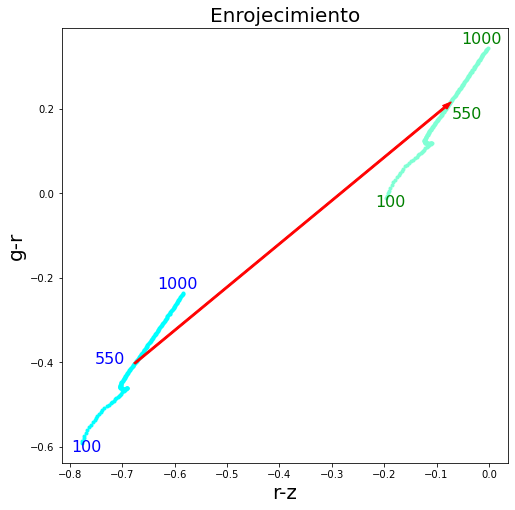

In [61]:
d=0
plt.figure(figsize=(8,8))
for a,b,age in zip(simulaciones_base[0],simulaciones_finales[0],edades):
    if d==0:
        #print(a[0])
        plt.text(a[0]-0.02,a[1]-0.02,age,color='blue',fontsize=16)
        plt.text(b[0]-0.02,b[1]-0.02,age,color='g',fontsize=16)
    if d==180:
        plt.text(a[0]-0.05,a[1]+0.01,age,color='blue',fontsize=16)
        plt.text(b[0]-0.05,b[1]+0.01,age,color='g',fontsize=16)
    if round((len(simulaciones_base[0])-1)/2)==d:
        plt.arrow(a[0],a[1],0.605,0.62,width=0.004,length_includes_head=True,color='red')
        plt.text(a[0]-0.075,a[1],age,color='blue',fontsize=16)
        plt.text(b[0]+0.025,b[1],age,color='g',fontsize=16)
        
    plt.scatter(a[0],a[1],marker='.',color='cyan')
    plt.scatter(b[0],b[1],marker='.',color='aquamarine')
    
    d+=1
plt.title('Enrojecimiento',fontsize=20)
plt.xlabel('r-z',fontsize=20)
plt.ylabel('g-r',fontsize=20)
#plt.savefig('Red.png',format='png')
plt.show()

# 

In [48]:
rectangulos = [] #debe almacenar los coeficientes (coef_,intercept_) de las rectas de los 4 lados por modelo (5)
for shemax,shemin,sbase,sfin in zip(simulaciones_hcg_ext_maximos,simulaciones_hcg_ext_minimos,simulaciones_base,simulaciones_finales):
    x_shemax = []
    x_shemin = []
    x_sbase = []
    x_sfin = []
    
    y_shemax = []
    y_shemin = []
    y_sbase = []
    y_sfin = []
    
    for v_shemax,v_shemin,v_sbase,v_sfin in zip(shemax,shemin,sbase,sfin):
        if len(shemax)==2:
            print(v_sbase)
        x_shemax.append(v_shemax[0])
        x_shemin.append(v_shemin[0])
        x_sbase.append(v_sbase[0])
        x_sfin.append(v_sfin[0])
        y_shemax.append(v_shemax[1])
        y_shemin.append(v_shemin[1])
        y_sbase.append(v_sbase[1])
        y_sfin.append(v_sfin[1])
        
    rect_shemax = rectas(x_shemax,y_shemax)
    rect_shemin = rectas(x_shemin,y_shemin)
    rect_sbase = rectas(x_sbase,y_sbase)
    rect_sfin = rectas(x_sfin,y_sfin)
    
    rectangulos.append([rect_sbase,rect_shemax,rect_sfin,rect_shemin])

ValueError: With n_samples=1, test_size=None and train_size=0.5, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [49]:
rectangulos100 = rectangulos[4]
rectangulos100[0][0]

IndexError: list index out of range

5

In [190]:
puntos_dentro = []
limites_rect = []
for rz,gr in zip(hcg_rz,hcg_gr):
    aux_salida = []
    aux_rect = []
    for rz_,gr_,m in zip(rz,gr,rectangulos):
            
        baseline = [(m[0][0]*r_z)+m[0][1] for r_z in rz_] 
        maxline = [(m[1][0]*r_z)+m[1][1] for r_z in rz_] 
        redline = [(m[2][0]*r_z)+m[2][1] for r_z in rz_] 
        minline = [(m[3][0]*r_z)+m[3][1] for r_z in rz_] 
            
        aux_gr = [(r_z,g_r) for g_r,r_z,bl,mxl,rl,mnl in zip(gr_,rz_,baseline,maxline,redline,minline) if mnl<=g_r<=mxl]
        aux_salida.append(aux_gr)
        aux_rect.append([rz_,baseline,maxline,redline,minline])
    
    puntos_dentro.append(aux_salida)
    limites_rect.append(aux_rect)

In [287]:
len(hcg100_rz),len(hcg100_gr),len(ra_hcg100_tables ),len(dec_hcg100_tables)

(1077, 1077, 1077, 1077)

In [292]:
puntos_dentro100 = []
limites_rect100 = []
for rz,gr,ra,dec in zip(hcg100_rz,hcg100_gr,(ra_hcg100_tables ),(dec_hcg100_tables)):
    aux_salida = []
    aux_rect ='¡' []

    for rz__,gr__ in zip(rz,gr):
        for r_z,g_r in zip(rz__,gr__):
             
  
            baseline = (rectangulos100[0][0]*r_z)+rectangulos100[0][1]  
            maxline = (rectangulos100[1][0]*r_z)+rectangulos100[1][1]
            redline = (rectangulos100[2][0]*r_z)+rectangulos100[2][1]
            minline = (rectangulos100[3][0]*r_z)+rectangulos100[3][1]
        
            if  minline<=g_r<=maxline and baseline<=g_r<=redline:
                aux_gr100 = (r_z,g_r,ra,dec)
                aux_salida.append(aux_gr100)
                aux_rect.append([rz,baseline,maxline,redline,minline])
    #print(len(rz[1]))
                puntos_dentro100.append(aux_salida)
                limites_rect100.append(aux_rect)


(0.4196891784667969,
 0.8425655364990234,
 0.2566158851750747,
 13.099022341166341)

In [308]:
pd100 = Table()
gr100 = []
rz100 = []
ra100 = []
dec100 = []

for pto in puntos_dentro100:
    ra100.append(pto[0][2])
    dec100.append(pto[0][3])
pd100['ra'] =unique(ra100)
pd100['dec'] = unique(dec100)
pd100.write('cooordenadas_HCG100',format='ascii')

In [192]:
hcg = [2,6,7,16,22,26,31,89,96,100]

In [193]:
por_c=[]
for names,i in zip(hcg,puntos_dentro):
    c=0
    s=0
    for j in i:
        s+=1
        c+=len(j)
        if len(j)==0:
            pass
        else:
            print(f'El cruce del conjunto de datos de HCG {names} con el modelo {s}: {len(j)}')
    por_c.append(f'HCG {names} contiene {c} entre las 5 simulaciones (combinadas)')



El cruce del conjunto de datos de HCG 2 con el modelo 1: 18
El cruce del conjunto de datos de HCG 2 con el modelo 2: 838
El cruce del conjunto de datos de HCG 2 con el modelo 3: 10
El cruce del conjunto de datos de HCG 2 con el modelo 4: 680
El cruce del conjunto de datos de HCG 2 con el modelo 5: 1404
El cruce del conjunto de datos de HCG 6 con el modelo 1: 6
El cruce del conjunto de datos de HCG 6 con el modelo 2: 214
El cruce del conjunto de datos de HCG 6 con el modelo 3: 1
El cruce del conjunto de datos de HCG 6 con el modelo 4: 199
El cruce del conjunto de datos de HCG 6 con el modelo 5: 357
El cruce del conjunto de datos de HCG 7 con el modelo 1: 92
El cruce del conjunto de datos de HCG 7 con el modelo 2: 1689
El cruce del conjunto de datos de HCG 7 con el modelo 3: 18
El cruce del conjunto de datos de HCG 7 con el modelo 4: 1356
El cruce del conjunto de datos de HCG 7 con el modelo 5: 2743
El cruce del conjunto de datos de HCG 16 con el modelo 1: 70
El cruce del conjunto de dat

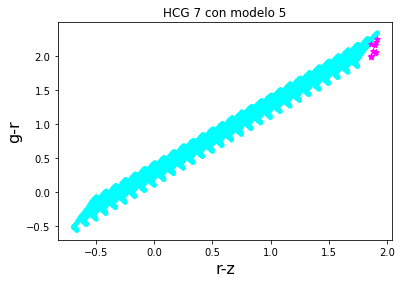

In [198]:
hcg__ = 2
model__ = 4
plt.scatter(all_rz_hcg_ext[model__],all_gr_hcg_ext[model__],marker='.',c='cyan')
for hc_g in puntos_dentro[hcg__][model__]:
    if hc_g[0]>=1.85:
        plt.scatter(hc_g[0],hc_g[1],marker='*',c='magenta')

plt.title(f'HCG {hcg[hcg__]} con modelo {identificador_sim[model__]}')
plt.xlabel('r-z',fontsize=16)
plt.ylabel('g-r',fontsize=16)
plt.show()


In [64]:
z_ = ['Z=0.008','Z=0.02','Z=0.05']
m_ = ['$10^6$','$10^8$']
zm = []
for m in m_:
    for z in z_:
        zm.append((m,z))
zm.remove(zm[1])
zm

[('$10^6$', 'Z=0.008'),
 ('$10^6$', 'Z=0.05'),
 ('$10^8$', 'Z=0.008'),
 ('$10^8$', 'Z=0.02'),
 ('$10^8$', 'Z=0.05')]

In [86]:
len(puntos_dentro)

10

In [87]:
pdx = []
pdy = []
for h_c in puntos_dentro:
    aux_X = []
    aux_Y = []
    for mod in h_c:
        aux_mod_x = []
        aux_mod_y = []
        for smod in mod:
            aux_mod_x.append(smod[0])
            aux_mod_y.append(smod[1])
        aux_X.append(aux_mod_x)
        aux_Y.append(aux_mod_y)
    pdx.append(aux_X)
    pdy.append(aux_Y)
len(pdx),len(pdy)

(10, 10)

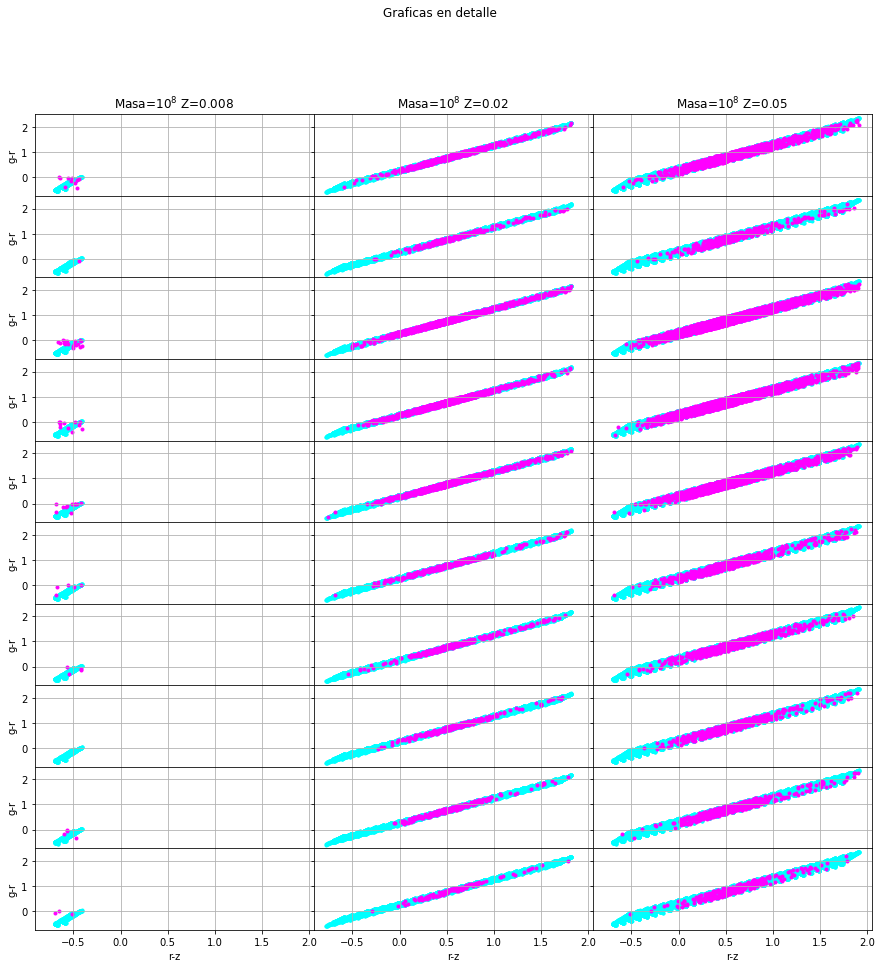

In [91]:


hcg__f = [i for i in range(0,len(hcg))]
model__f = [3,4,5]
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(10, 3, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

fig.suptitle('Graficas en detalle')
c=0
s=0

for hf in hcg__f:
    c=0
    for mf in (model__f):
        axs[s,c].scatter(all_rz_hcg_ext[mf-1],all_gr_hcg_ext[mf-1],marker='.',c='cyan')

        axs[s,c].scatter(pdx[hf][mf-1],pdy[hf][mf-1],marker='.',c='magenta')
        if s==0:
            axs[s,c].set_title(f'Masa={zm[mf-1][0]} {zm[mf-1][1]}')
        axs[s,c].grid()
        c+=1
    s+=1
    
#plt.title(f'HCG {hcg[hcg__]} con modelo {identificador_sim[model__]}')

for ax in axs.flat:

    ax.set(xlabel='r-z', ylabel='g-r')
for ax in axs.flat:
    ax.label_outer()

plt.savefig('Test_02.png',format='png')
plt.show()


In [ ]:
hcg__f

In [68]:
X = np.array([-0.6644667949617311,-0.6663168875099519])
y = np.array([-0.5511493021251788,-0.549587872176156])
X_train, X_test, y_train, y_test = train_test_split(
                                        X.reshape(-1,1),
                                        y.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)
float(modelo.coef_[0]),modelo.intercept_[0]

(0.0, -0.549587872176156)

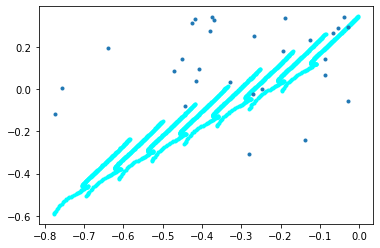

In [69]:
modelos = 0
a=hcg_rz[1][modelos]
b=hcg_gr[1][modelos]


#for i,j in zip((all_rz_hcg_ext),(all_gr_hcg_ext)):
plt.scatter(all_rz_hcg_ext[modelos],all_gr_hcg_ext[modelos],marker='.',c='cyan')
    
plt.scatter(a,b,marker='.')

#plt.xlim(-1,2)
#plt.ylim(-1,2)
plt.show()

In [70]:
corr_test = pearsonr(x = (all_rz_hcg_ext[modelos][len(all_rz_hcg_ext[modelos])-1]), y =  (all_gr_hcg_ext[modelos][len(all_gr_hcg_ext[modelos])-1]))
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  0.9953907141974687
P-value:  3.346593458794388e-184


In [71]:
X = np.array(all_rz_hcg_ext[modelos][len(all_rz_hcg_ext[modelos])-1])
y = np.array(all_gr_hcg_ext[modelos][len(all_gr_hcg_ext[modelos])-1])
X_train, X_test, y_train, y_test = train_test_split(
                                        X.reshape(-1,1),
                                        y.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)
float(modelo.coef_[0]),modelo.intercept_[0]

(1.8346329709199087, 0.3490935836612284)

In [72]:
print("Intercept:", modelo.intercept_)
print("Coeficiente:", list(zip(modelo.coef_.flatten() )))
print("Coeficiente de determinación R^2:", modelo.score(X.reshape(-1,1), y))

Intercept: [0.34909358]
Coeficiente: [(1.8346329709199087,)]
Coeficiente de determinación R^2: 0.9907974220441266


In [73]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)

modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.561e+04
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          4.34e-147
Time:                        03:10:51   Log-Likelihood:                 484.58
No. Observations:                 144   AIC:                            -965.2
Df Residuals:                     142   BIC:                            -959.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3491      0.001    234.143      0.0

In [74]:
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones.head(4)


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.134427,0.000809,0.132827,0.136026,0.117704,0.151149
1,0.124845,0.000850,0.123165,0.126526,0.108115,0.141576
2,0.130783,0.000824,0.129154,0.132412,0.114057,0.147509
3,0.169575,0.000712,0.168167,0.170983,0.152870,0.186281


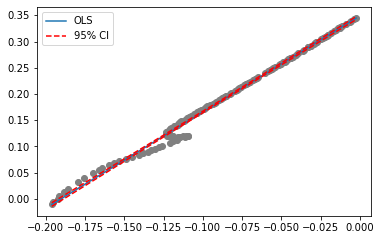

In [75]:
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones['x'] = X_train[:, 1]
predicciones['y'] = y_train
predicciones = predicciones.sort_values('x')

fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.1)
ax.legend();

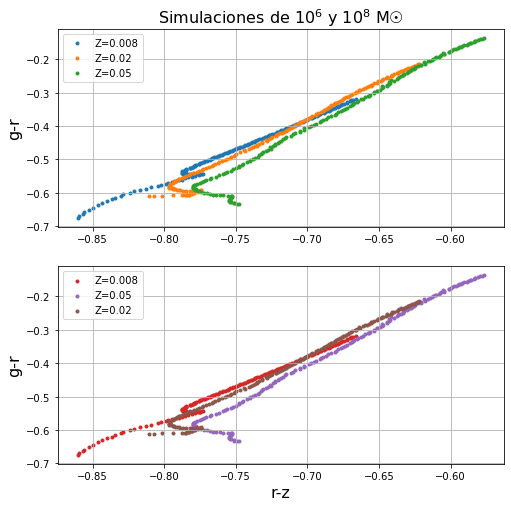

In [76]:
c=0

plt.figure(figsize=(8,8))

for i,z,col in zip(gr_general,rz_general,color_candidatos[:len(color_candidatos)-1]):
    if c<=2:
        plt.title(f'Simulaciones de $10^6$ y $10^8$ M☉', fontsize = 16)
        ax1 = plt.subplot(211)

        ax1.scatter(z,i,marker='.',c=col)
        ax1.legend(['Z=0.008','Z=0.02','Z=0.05'])
        ax1.grid()
        #plt.xlabel('r-z', fontsize = 16)
        plt.ylabel('g-r', fontsize = 16)

    
    else:
        
        ax2 = plt.subplot(212)
        
        ax2.scatter(z,i,marker='.',c=col)
        ax2.legend(['Z=0.008','Z=0.05','Z=0.02'])
        ax2.grid()
        plt.xlabel('r-z', fontsize = 16)
        plt.ylabel('g-r', fontsize = 16)


    c+=1

plt.savefig('Simulaciones.png', format='png')
plt.show()